In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pulp import *

In [197]:
inputs = pd.read_csv('inputs.csv', index_col=0, delimiter=';')
outputs = pd.read_csv('outputs.csv', index_col=0, delimiter=';')
samples = pd.read_csv('samples_homework.csv', delimiter=';')

In [198]:
efficiency_scores = {}
reference_units = {}
adjustments = {}
super_efficiency_scores = {}
cross_efficiency_scores = {DMU: [] for DMU in inputs.index}
expected_efficiency = {}

In [199]:
#  Calculate efficiency and super-efficiency for each DMU
for DMUo in inputs.index:
    problem = LpProblem(f"Efficiency_{DMUo}", LpMinimize)
    lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
    theta = LpVariable("theta", lowBound=0, upBound=1)

    problem += theta

    for input_metric in inputs.columns:
        problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric]

    for output_metric in outputs.columns:
        problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] for i in inputs.index]) >= outputs.loc[DMUo, output_metric]

    problem.solve(PULP_CBC_CMD(msg=False))

    if LpStatus[problem.status] == 'Optimal':
        efficiency_score = value(theta)
        efficiency_scores[DMUo] = efficiency_score

        if efficiency_score < 1:
            reference_units[DMUo] = {}
            adjustments[DMUo] = {}
            for i in inputs.index:
                if lambdas[i].varValue > 0:
                    reference_units[DMUo][i] = lambdas[i].varValue

            for input_metric in inputs.columns:
                optimal_input = sum(lambdas[i].varValue * inputs.loc[i, input_metric] for i in inputs.index)
                adjustments[DMUo][input_metric] = inputs.loc[DMUo, input_metric] - optimal_input

    else:
        print(f"Problem for {DMUo} is not solvable")
    
    # Superefektywność
    super_problem = LpProblem(f"SuperEfficiency_{DMUo}", LpMinimize)
    super_lambdas = LpVariable.dicts("SuperLambda", (i for i in inputs.index if i != DMUo), lowBound=0)
    super_theta = LpVariable("super_theta", lowBound=0)

    super_problem += super_theta
    for input_metric in inputs.columns:
        super_problem += lpSum([super_lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index if i != DMUo]) <= super_theta * inputs.loc[DMUo, input_metric]
    for output_metric in outputs.columns:
        super_problem += lpSum([super_lambdas[i] * outputs.loc[i, output_metric] for i in inputs.index if i != DMUo]) >= outputs.loc[DMUo, output_metric]
    
    super_problem.solve(PULP_CBC_CMD(msg=False))
    if LpStatus[super_problem.status] == 'Optimal':
        super_efficiency_scores[DMUo] = 1 / value(super_theta)

# Calculate cross-efficiency and expected efficiency
for DMUo in inputs.index:
    all_efficiencies = []
    for index, sample in samples.iterrows():
        problem = LpProblem(f"SampleEfficiency_{DMUo}_{index}", LpMinimize)
        lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
        theta = LpVariable("theta", lowBound=0, upBound=1)
        
        problem += theta
        for input_metric in inputs.columns:
            problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] * sample[input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric] * sample[input_metric]
        for output_metric in outputs.columns:
            problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] * sample[output_metric] for i in inputs.index]) >= outputs.loc[DMUo, output_metric] * sample[output_metric]

        problem.solve(PULP_CBC_CMD(msg=False))
        if LpStatus[problem.status] == 'Optimal':
            all_efficiencies.append(value(theta))

    cross_efficiency_scores[DMUo].extend(all_efficiencies)
    expected_efficiency[DMUo] = np.mean(all_efficiencies)


# Display the results
for airport, efficiency in efficiency_scores.items():
    print(f"Efficiency for {airport}: {efficiency:.2f}")
    if airport in super_efficiency_scores:
        print(f"Super Efficiency for {airport}: {super_efficiency_scores[airport]:.2f}")
    if airport in adjustments:
        print(f"Adjustments for {airport}:")
        for metric, value in adjustments[airport].items():
            print(f"  {metric}: reduce to {value:.2f}")
    if airport in reference_units:
        print(f"Reference Units for {airport}:")
        for unit, value in reference_units[airport].items():
            print(f"  {unit}: {value:.2f}")
    print(f"Expected Efficiency for {airport}: {expected_efficiency[airport]:.2f}")

Efficiency for WAW: 1.00
Super Efficiency for WAW: 0.44
Expected Efficiency for WAW: 1.00
Efficiency for KRK: 1.00
Super Efficiency for KRK: 0.89
Expected Efficiency for KRK: 1.00
Efficiency for KAT: 0.59
Super Efficiency for KAT: 1.69
Adjustments for KAT:
  i1: reduce to 1.47
  i2: reduce to 13.08
  i3: reduce to 23.46
  i4: reduce to 6.10
Reference Units for KAT:
  KRK: 0.00
  WRO: 1.23
  GDN: 0.27
Expected Efficiency for KAT: 0.59
Efficiency for WRO: 1.00
Super Efficiency for WRO: 0.96
Expected Efficiency for WRO: 1.00
Efficiency for POZ: 0.80
Super Efficiency for POZ: 1.25
Adjustments for POZ:
  i1: reduce to 0.30
  i2: reduce to 2.00
  i3: reduce to 4.80
  i4: reduce to 2.07
Reference Units for POZ:
  WAW: 0.05
  KRK: 0.07
  WRO: 0.20
  GDN: 0.16
Expected Efficiency for POZ: 0.80
Efficiency for LCJ: 0.30
Super Efficiency for LCJ: 3.33
Adjustments for LCJ:
  i1: reduce to 0.42
  i2: reduce to 9.22
  i3: reduce to 16.80
  i4: reduce to 3.43
Reference Units for LCJ:
  GDN: 0.16
  BZG

In [202]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, PULP_CBC_CMD, LpStatus, value

# Assuming the necessary data frames 'inputs' and 'outputs' are already defined
samples = pd.read_csv('samples_homework.csv')
cross_efficiency_matrix = pd.DataFrame(index=inputs.index, columns=inputs.index)

# Calculate cross-efficiency for each DMU
for DMUo in inputs.index:
    for DMU in inputs.index:
        if DMU != DMUo:
            problem = LpProblem(f"CrossEfficiency_{DMUo}_using_{DMU}", LpMinimize)
            lambdas = LpVariable.dicts("Lambda", (i for i in inputs.index), lowBound=0)
            theta = LpVariable("theta", lowBound=0, upBound=1)

            problem += theta

            for input_metric in inputs.columns:
                problem += lpSum([lambdas[i] * inputs.loc[i, input_metric] for i in inputs.index]) <= theta * inputs.loc[DMUo, input_metric]

            for output_metric in outputs.columns:
                problem += lpSum([lambdas[i] * outputs.loc[i, output_metric] for i in inputs.index]) >= outputs.loc[DMUo, output_metric]

            problem.solve(PULP_CBC_CMD(msg=False))

            if LpStatus[problem.status] == 'Optimal':
                cross_efficiency_matrix.loc[DMUo, DMU] = value(theta)
        else:
            cross_efficiency_matrix.loc[DMUo, DMU] = 1  # Self-evaluation is always 1

# Calculate average cross-efficiency
cross_efficiency_matrix['CRavg'] = cross_efficiency_matrix.mean(axis=1)

# # Display the cross-efficiency matrix
# print("Cross-Efficiency Matrix:")
# print(cross_efficiency_matrix)

# Save the cross-efficiency matrix to a CSV file (optional)
cross_efficiency_matrix.to_csv('cross_efficiency_matrix.csv', index=True)

# Format the table for display
table_format = cross_efficiency_matrix.reset_index().to_markdown(index=False)
print(table_format)


| index   |      WAW |      KRK |      KAT |      WRO |      POZ |      LCJ |      GDN |      SZZ |      BZG |      RZE |      IEG |    CRavg |
|:--------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| WAW     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| KRK     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| KAT     | 0.591209 | 0.591209 | 1        | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.591209 | 0.628372 |
| WRO     | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        | 1        |
| POZ     | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 1        | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.799801 | 0.8

In [141]:
# Create DataFrame for reference units (HCU)
reference_units_df = pd.DataFrame(reference_units).fillna(0)

# Calculate HCU values
hcu_values = {}
for DMU, refs in reference_units.items():
    hcu_values[DMU] = {}
    for input_metric in inputs.columns:
        hcu_values[DMU][input_metric] = sum(refs[i] * inputs.loc[i, input_metric] for i in refs)

hcu_df = pd.DataFrame(hcu_values).T

# Ensure all DMUs are included
for DMU in inputs.index:
    if DMU not in hcu_df.index:
        hcu_df.loc[DMU] = np.nan
    if DMU not in adjustments_df.index:
        adjustments_df.loc[DMU] = np.nan

# Fill NaN values with 0 for effective DMUs
hcu_df = hcu_df.fillna(0)
adjustments_df = (inputs - hcu_df).fillna(0)

# Ensure that the DataFrames have the same columns
hcu_df = hcu_df[inputs.columns]
adjustments_df = adjustments_df[inputs.columns]

# Combine HCU and Adjustments into a single DataFrame
combined_df = pd.concat([hcu_df, adjustments_df], axis=1)

# Rename columns to match the format
new_columns = [f'HCU_{col}' for col in hcu_df.columns] + [f'Poprawki_{col}' for col in adjustments_df.columns]
combined_df.columns = new_columns

# # Display the combined DataFrame
# print("Combined HCU and Adjustments Table:")
# print(combined_df)

# Save the combined table to a CSV file (optional)
combined_df.to_csv('hcu_and_adjustments.csv', index=True)

# Format the table for display
table_format = combined_df.reset_index().to_markdown(index=False)
print(table_format)

| index   |    HCU_i1 |    HCU_i2 |   HCU_i3 |    HCU_i4 |   Poprawki_i1 |   Poprawki_i2 |   Poprawki_i3 |   Poprawki_i4 |
|:--------|----------:|----------:|---------:|----------:|--------------:|--------------:|--------------:|--------------:|
| KAT     | 2.12835   | 18.9187   | 33.9354  | 4.39648   |     1.47165   |      13.0813  |      23.4646  |       6.10352 |
| POZ     | 1.1997    |  7.99801  | 19.1952  | 1.92843   |     0.300299  |       2.00199 |       4.80478 |       2.07157 |
| LCJ     | 0.180022  |  2.78302  |  7.20087 | 0.474862  |     0.419978  |       9.21698 |      16.7991  |       3.42514 |
| SZZ     | 0.189551  |  2.70787  |  6.95923 | 0.465305  |     0.510449  |       7.29213 |      18.7408  |       1.43469 |
| RZE     | 0.24551   |  2.4551   |  4.62377 | 0.53653   |     0.35449   |       3.5449  |       6.67623 |       2.16347 |
| IEG     | 0.0258475 |  0.387712 |  1.10886 | 0.0646186 |     0.0741525 |       9.61229 |      62.2911  |       2.93538 |
| WAW     | 0   

In [207]:
import pandas as pd

# Assume efficiency_scores, super_efficiency_scores, and expected_efficiency are dictionaries with the necessary data

# Create DataFrame for ranking
results_df = pd.DataFrame({
    'Efficiency': pd.Series(efficiency_scores),
    'SuperEfficiency': pd.Series(super_efficiency_scores),
    'ExpectedEfficiency': pd.Series(expected_efficiency)
})

# Rank units
results_df['EfficiencyRank'] = results_df['Efficiency'].rank(ascending=False)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiency'].rank(ascending=False)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiency'].rank(ascending=False)

# Display the rankings
results_df.sort_values(by='EfficiencyRank', inplace=True)
print("Rankings based on Efficiency, SuperEfficiency, and ExpectedEfficiency:")
print(results_df)

# Analyze the ranking consistency
results_df['EfficiencyRank'] = results_df['EfficiencyRank'].astype(int)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiencyRank'].astype(int)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiencyRank'].astype(int)

# Calculate Spearman rank correlation to check consistency
efficiency_super_corr = results_df[['EfficiencyRank', 'SuperEfficiencyRank']].corr(method='spearman').iloc[0, 1]
efficiency_expected_corr = results_df[['EfficiencyRank', 'ExpectedEfficiencyRank']].corr(method='spearman').iloc[0, 1]
super_expected_corr = results_df[['SuperEfficiencyRank', 'ExpectedEfficiencyRank']].corr(method='spearman').iloc[0, 1]

print(f"Spearman Rank Correlation between Efficiency and SuperEfficiency: {efficiency_super_corr:.2f}")
print(f"Spearman Rank Correlation between Efficiency and ExpectedEfficiency: {efficiency_expected_corr:.2f}")
print(f"Spearman Rank Correlation between SuperEfficiency and ExpectedEfficiency: {super_expected_corr:.2f}")

Rankings based on Efficiency, SuperEfficiency, and ExpectedEfficiency:
     Efficiency  SuperEfficiency  ExpectedEfficiency  EfficiencyRank  \
WAW    1.000000         0.438991            1.000000             3.0   
KRK    1.000000         0.889852            1.000000             3.0   
WRO    1.000000         0.961589            1.000000             3.0   
GDN    1.000000         0.500000            1.000000             3.0   
BZG    1.000000         0.572760            1.000000             3.0   
POZ    0.799801         1.250311            0.799801             6.0   
KAT    0.591209         1.691449            0.591209             7.0   
RZE    0.409183         2.443892            0.409183             8.0   
LCJ    0.300036         3.332931            0.300036             9.0   
SZZ    0.270787         3.692936            0.270787            10.0   
IEG    0.258475         3.868852            0.258475            11.0   

     SuperEfficiencyRank  ExpectedEfficiencyRank  
WAW          

In [208]:
# Create DataFrame for ranking
results_df = pd.DataFrame({
    'Efficiency': pd.Series(efficiency_scores),
    'SuperEfficiency': pd.Series(super_efficiency_scores),
    'ExpectedEfficiency': pd.Series(expected_efficiency)
})

# Rank units
results_df['EfficiencyRank'] = results_df['Efficiency'].rank(ascending=False)
results_df['SuperEfficiencyRank'] = results_df['SuperEfficiency'].rank(ascending=False)
results_df['ExpectedEfficiencyRank'] = results_df['ExpectedEfficiency'].rank(ascending=False)

# Sort DataFrame by ranks
efficiency_ranking = results_df.sort_values(by='EfficiencyRank').index.tolist()
super_efficiency_ranking = results_df.sort_values(by='SuperEfficiencyRank').index.tolist()
expected_efficiency_ranking = results_df.sort_values(by='ExpectedEfficiencyRank').index.tolist()

# Format rankings into the desired output
super_efficiency_str = " ≻ ".join(super_efficiency_ranking)
average_efficiency_str = " ≻ ".join(efficiency_ranking)
expected_efficiency_str = " ≻ ".join(expected_efficiency_ranking)

# Print the formatted rankings
print(f"Superefektywność: {super_efficiency_str}")
print(f"Średnia efektywność krzyżowa: {average_efficiency_str}")
print(f"Oczekiwana wartość efektywności: {expected_efficiency_str}")

Superefektywność: IEG ≻ SZZ ≻ LCJ ≻ RZE ≻ KAT ≻ POZ ≻ WRO ≻ KRK ≻ BZG ≻ GDN ≻ WAW
Średnia efektywność krzyżowa: WAW ≻ KRK ≻ WRO ≻ GDN ≻ BZG ≻ POZ ≻ KAT ≻ RZE ≻ LCJ ≻ SZZ ≻ IEG
Oczekiwana wartość efektywności: WAW ≻ KRK ≻ WRO ≻ GDN ≻ BZG ≻ POZ ≻ KAT ≻ RZE ≻ LCJ ≻ SZZ ≻ IEG


Efficiency Distribution for Each DMU:
     [0-0.2]  [0.2-0.4]  [0.4-0.6]  [0.6-0.8]  [0.8-1.0]        EE
WAW        0          0          0          0        100  1.000000
KRK        0          0          0          0        100  1.000000
KAT        0          0        100          0          0  0.591209
WRO        0          0          0          0        100  1.000000
POZ        0          0          0        100          0  0.799801
LCJ        0        100          0          0          0  0.300036
GDN        0          0          0          0        100  1.000000
SZZ        0        100          0          0          0  0.270787
BZG        0          0          0          0        100  1.000000
RZE        0          0        100          0          0  0.409183
IEG        0        100          0          0          0  0.258475


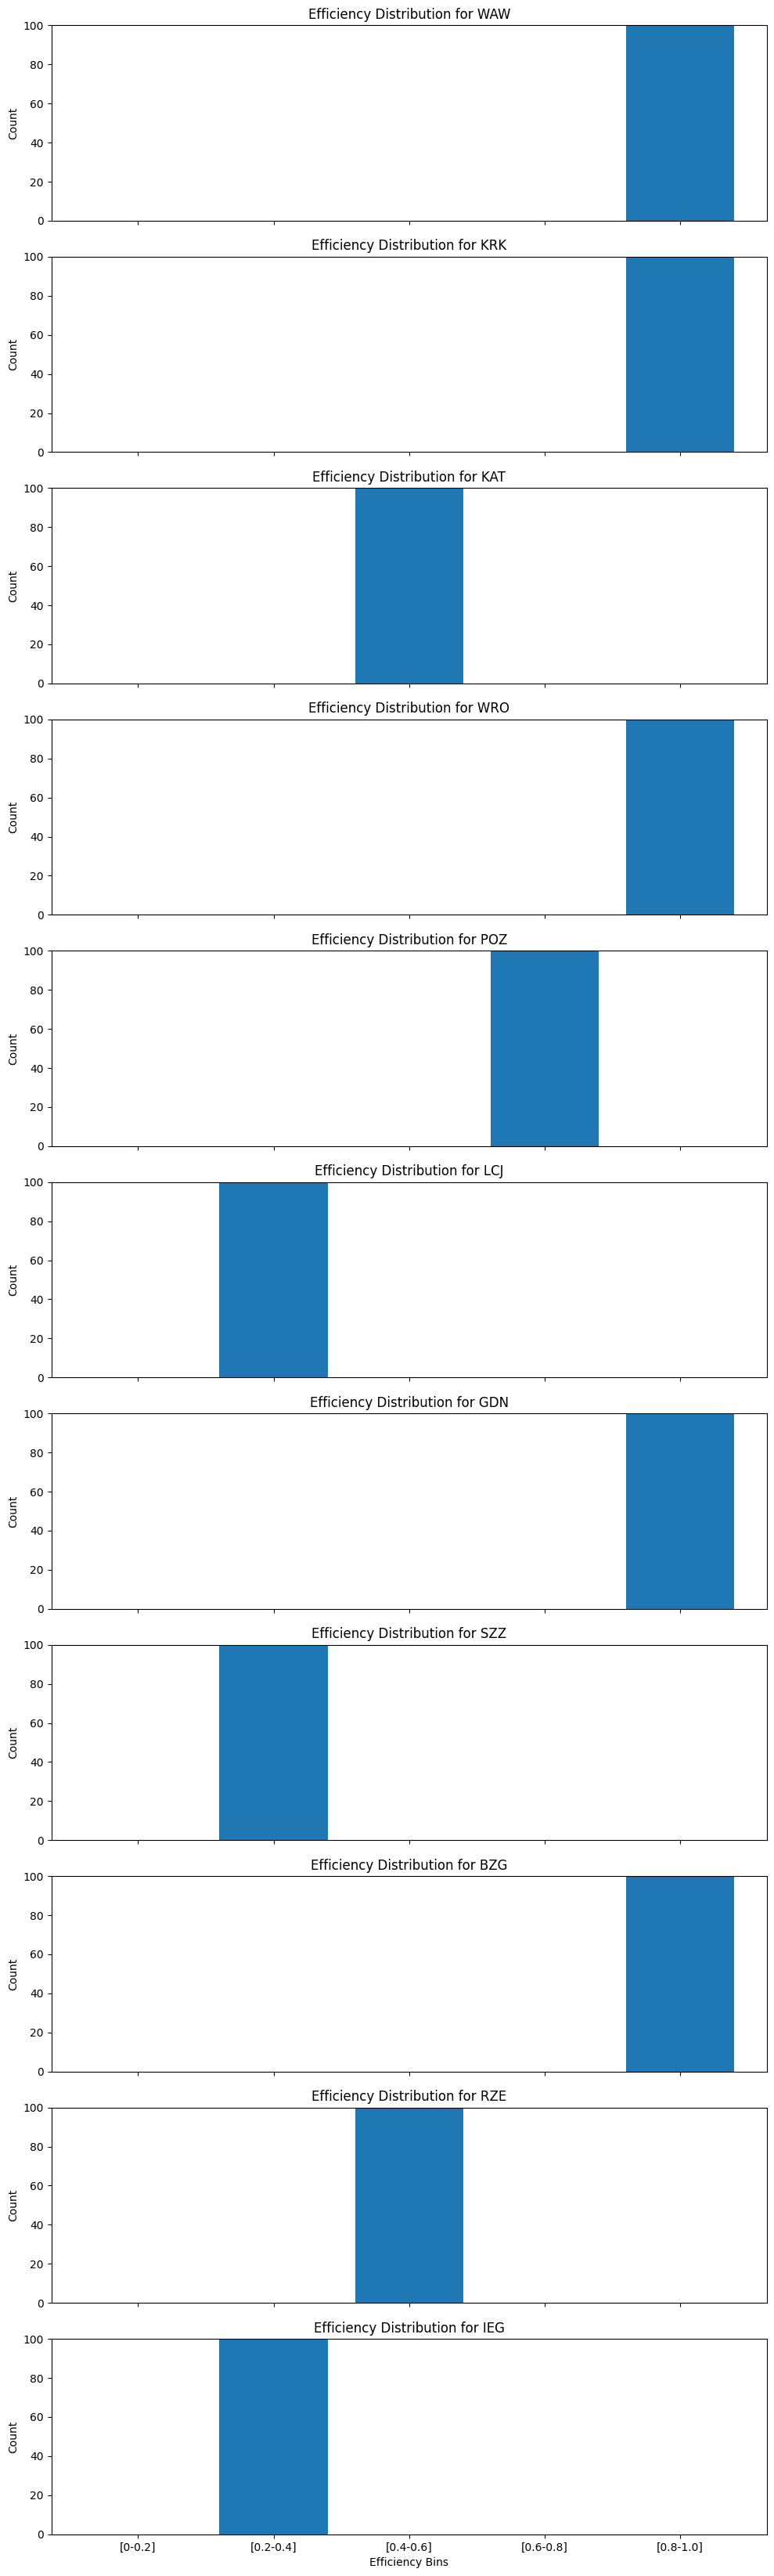

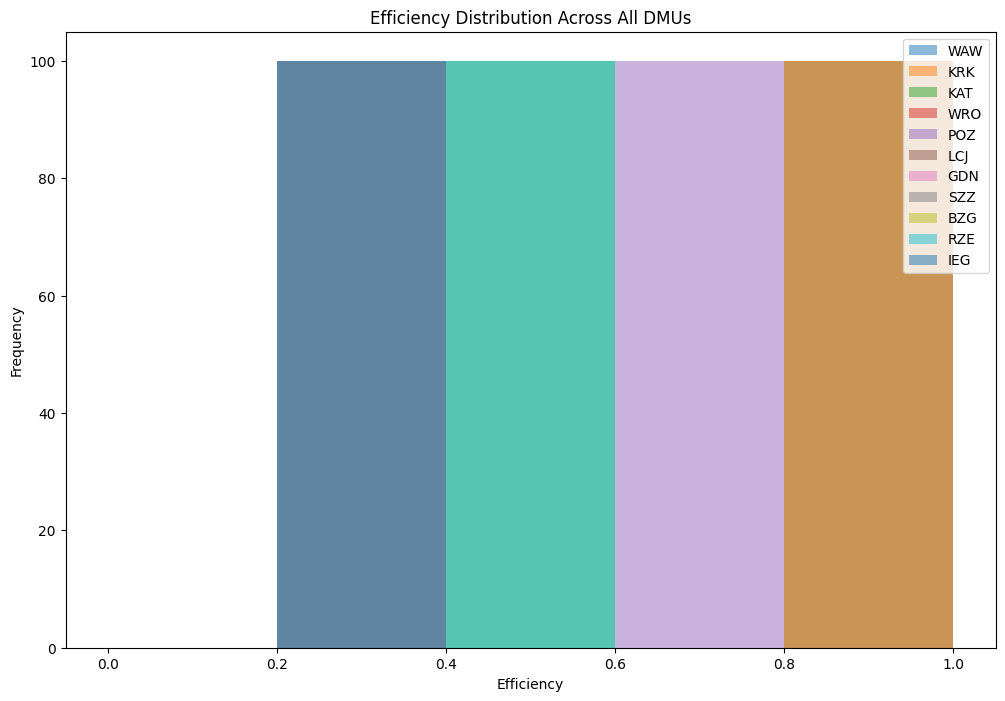

In [205]:
# Create smaller bins for better visualization
bins = np.linspace(0, 1, 6)  # Adjust the number of bins to match the table
bin_labels = ['[0-0.2]', '[0.2-0.4]', '[0.4-0.6]', '[0.6-0.8]', '[0.8-1.0]']

# Calculate efficiency distributions
efficiency_distributions = {DMU: np.histogram(cross_efficiency_scores[DMU], bins=bins)[0] for DMU in inputs.index}

# Create DataFrame for distribution
distribution_df = pd.DataFrame(efficiency_distributions).T
distribution_df.columns = bin_labels

# Add expected efficiency column
distribution_df['EE'] = distribution_df.index.map(expected_efficiency)

# Display the distribution
print("Efficiency Distribution for Each DMU:")
print(distribution_df)

# Plot the distributions for each DMU
fig, axs = plt.subplots(len(inputs.index), 1, figsize=(10, len(inputs.index)*3), sharex=True)

for idx, DMU in enumerate(inputs.index):
    axs[idx].bar(distribution_df.columns[:-1], distribution_df.loc[DMU][:-1])  # Exclude 'EE' column for plotting
    axs[idx].set_title(f'Efficiency Distribution for {DMU}')
    axs[idx].set_ylabel('Count')
    axs[idx].set_ylim(0, max(distribution_df.max()))
    axs[idx].set_xticks(range(len(bin_labels)))
    axs[idx].set_xticklabels(bin_labels)

plt.xlabel('Efficiency Bins')
plt.tight_layout()
plt.show()

# Combined histogram for all DMUs
plt.figure(figsize=(12, 8))
for DMU, efficiencies in cross_efficiency_scores.items():
    plt.hist(efficiencies, bins=bins, alpha=0.5, label=DMU)
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Efficiency Distribution Across All DMUs')
plt.legend(loc='upper right')
plt.show()

# import ace_tools as tools; tools.display_dataframe_to_user(name="Efficiency Distribution Table", dataframe=distribution_df)
